In [1]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *
from qiskit import pulse

/home/riccardo/.venv/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver

gate_backend = FakeManila()
gate_backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2}
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")
pulse_backend = DynamicsBackend.from_backend(gate_backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
pulse_backend.set_options(solver_options=solver_options)
pulse_backend.configuration = lambda: gate_backend.configuration()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
simplified_h2_molecule = """
H 0.0 0.0 0.0
H 0.0 0.0 0.735
"""

driver = PySCFDriver(
    atom=simplified_h2_molecule.strip(),
    basis='sto3g',
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

qmolecule = driver.run()

/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
from qiskit_nature import settings
settings.use_pauli_sum_op = False

In [5]:
hamiltonian = qmolecule.hamiltonian
coefficients = hamiltonian.electronic_integrals
second_q_op = hamiltonian.second_q_op()
print(second_q_op)
nuclear_cont = hamiltonian.nuclear_repulsion_energy

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600884 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600884 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507

In [6]:
print(coefficients.alpha)

Polynomial Tensor
 "+-":
array([[-1.25633907e+00, -1.37083854e-17],
       [-6.07732712e-17, -4.71896007e-01]])
 "++--":
array([6.75710155e-01, 1.38777878e-16, 1.80931200e-01, 6.64581730e-01,
       5.55111512e-17, 6.98573723e-01])


In [7]:
print(coefficients.beta)

Polynomial Tensor
 


In [8]:
print(coefficients.beta_alpha)

Polynomial Tensor
 


In [9]:
import re

mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)
print(qubit_op)

my_dict = {}

for pauli in qubit_op:
    #print(pauli)
    str_info = pauli.__str__()
    print(f"Rappresentazione della stringa: {str_info}")

    # Estrai i coefficienti
    coeffs_start = str_info.find("coeffs=[") + len("coeffs=[")
    coeffs_end = str_info.find("]", coeffs_start)
    coeffs_str = str_info[coeffs_start:coeffs_end].strip()
    
    # Estrai gli operatori come stringa
    operators_start = str_info.find("Op(['") + len("Op(['")
    operators_end = str_info.find("'])", operators_start)
    operators_str = str_info[operators_start:operators_end]

    # Utilizza espressioni regolari per estrarre la parte reale e immaginaria dei coefficienti
    coeffs_match = re.findall(r"(-?\d+\.\d+)([+-]\d+\.\d+j)?", coeffs_str)

    # Inizializza i coefficienti come float
    real_coeffs = [float(match[0]) for match in coeffs_match]
    imag_coeffs = [float(match[1]) if match[1] else 0.0 for match in coeffs_match]

    # Somma i coefficienti complessi
    complex_coeff = sum(complex(real, imag) for real, imag in zip(real_coeffs, imag_coeffs))

    # Aggiungi il coefficiente all'operatore nel dizionario
    current_coeff = my_dict.get(operators_str, 0.0)
    my_dict[operators_str] = current_coeff + complex_coeff
    
print(my_dict)


SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])
Rappresentazione della stringa: SparsePauliOp(['IIII'],
              coeffs=[-0.81054798+0.j])
Rappresentazione della stringa: SparsePauliOp(['IIIZ'],
              coeffs=[0.17218393+0.j])
Rappresentazione della stringa: SparsePauliOp(['IIZI'],
              coeffs=[-0.22575349+0.j])
Rappresentazione della stringa: SparsePauliOp(['IZII'],
              coeffs=[0.17218393+0.j])
Rappresentazione della stringa: SparsePauliOp(['ZIII'],
              coeffs=[-0.22575349+0.j])
Rappresentazione della stringa: SparsePauliOp(['IIZZ'],
              coeffs=[0.12091263+0.j])
Rappresent

In [10]:
from qiskit.pulse import Schedule, GaussianSquare, Drag, Delay, Play, ControlChannel, DriveChannel

def drag_pulse(backend, amp, angle):
    backend_defaults = backend.defaults()
    inst_sched_map = backend_defaults.instruction_schedule_map
    x_pulse = inst_sched_map.get('x', (0)).filter(channels=[DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
    x_pulse = inst_sched_map.get('x', (0)).filter(channels=[DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
    duration_parameter = x_pulse.parameters['duration']
    sigma_parameter = x_pulse.parameters['sigma']
    beta_parameter = x_pulse.parameters['beta']
    pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
    return pulse1

In [11]:
def cr_pulse(backend, amp, angle, duration):
    backend_defaults = backend.defaults()
    inst_sched_map = backend_defaults.instruction_schedule_map
    cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels=[ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
    cr_params = {
        'duration': cr_pulse.parameters['duration'],
        'amp': cr_pulse.parameters['amp'],
        'angle': cr_pulse.parameters['angle'],
        'sigma': cr_pulse.parameters['sigma'],
        'width': cr_pulse.parameters['width']
    }
    cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
    angle_parameter = angle
    duration_parameter = duration
    sigma_parameter = cr_pulse.parameters['sigma']
    width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
    pulse1 = GaussianSquare(duration=duration_parameter, amp=amp, angle=angle_parameter, sigma=sigma_parameter, width=width_parameter)

    return pulse1

In [12]:
import qiskit.pulse as pulse
def HE_pulse(backend, amp, angle, width):
    # Crea un programma di impulsi vuoto
    with pulse.build(backend) as my_program1:
        sched_list = []
        # Layer 1: Applica una porta X su ciascun qubit
        with pulse.build(backend) as sched1:
            qubits = (0, 1, 2, 3, 4)
            for i in range(4):
                pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
            sched_list.append(sched1)

        # Layer 2: Applica una porta di controllo tra qubit 0 e 1
        with pulse.build(backend) as sched2:
            uchan = pulse.control_channels(0, 1)[0]
            pulse.play(cr_pulse(backend, amp[4], angle[4], width[0]), uchan)
            sched_list.append(sched2)

        # Layer 3: Applica una porta di controllo tra qubit 1 e 2
        with pulse.build(backend) as sched4:
            uchan = pulse.control_channels(1, 2)[0]
            pulse.play(cr_pulse(backend, amp[5], angle[5], width[1]), uchan)
            sched_list.append(sched4)

        # Layer 4: Applica una porta di controllo tra qubit 2 e 3
        with pulse.build(backend) as sched6:
            uchan = pulse.control_channels(2, 3)[0]
            pulse.play(cr_pulse(backend, amp[6], angle[6], width[2]), uchan)
            sched_list.append(sched6)

        # Costruisci il programma principale allineando sequenzialmente gli schedule
        with pulse.build(backend) as my_program:
            with pulse.transpiler_settings(initial_layout=[0, 1, 2, 3]):
                with pulse.align_sequential():
                    for sched in sched_list:
                        pulse.call(sched)

    return my_program

In [13]:
import copy
from scipy.optimize import minimize, LinearConstraint

def measurement_pauli(prepulse, pauli_string, backend, n_qubit):
    with pulse.build(backend) as pulse_measure:
        pulse.call(copy.deepcopy(prepulse))
        for ind, pauli in enumerate(pauli_string):
            if pauli == 'X':
                pulse.u2(0, np.pi, ind)
            elif pauli == 'Y':
                pulse.u2(0, np.pi / 2, ind)
        for qubit in range(n_qubit):
            pulse.barrier(qubit)
        pulse.measure(range(n_qubit))
    return pulse_measure

def n_one(bitstring, key):
    results = 0
    for ind, b in enumerate(reversed(bitstring)):
        if b == '1' and key[ind] != 'I':
            results += 1
    return results

def expectation_value(counts, shots, key):
    results = 0
    for bitstring in counts:
        if n_one(bitstring, key) % 2 == 1:
            results -= counts[bitstring] / shots
        else:
            results += counts[bitstring] / shots
    return results

def run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot):
    results = pulse_backend.run(meas_pulse).result()
    counts = results.get_counts()
    expectation = expectation_value(counts, n_shot, key)
    return expectation

def gen_LC_vqe(parameters):
    lb = np.zeros(parameters)
    ub = np.ones(parameters)
    LC = LinearConstraint(np.eye(parameters), lb, ub, keep_feasible=False)
    return LC

In [14]:
def vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value):
    all_Is = all(key_ele == 'I' for key_ele in key)
    if all_Is:
        return value

    meas_pulse = measurement_pauli(prepulse=prepulse, pauli_string=key, backend=backend, n_qubit=n_qubit)

    return value * run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot)

In [15]:
def vqe(params, pauli_dict, pulse_backend, backend, n_qubit, n_shot):
    print("params in def chemistry in vqe.py: ", params)

    width_len = int(len(params) - 1 * (n_qubit - 1))

    split_ind = int(width_len / 2)

    # Estrai le ampiezze, gli angoli e le larghezze dalla lista dei parametri
    amp = np.array(params[:split_ind])
    angle = np.array(params[split_ind:width_len]) * np.pi * 2
    width_1 = np.array(params[width_len:])

    # Calcola il numero di intervalli di larghezza normalizzati
    num_items = (1024 - 256) // 16 + 1

    # Normalizza le larghezze tra 256 e 1024
    width_norm = (width_1 - 256) / (1024 - 256)
    width_norm = np.clip(width_norm, 0, 1)

    # Calcola le larghezze in base alla normalizzazione
    width = (np.round(width_norm * (num_items - 1)) * 16 + 256).astype(int)

    amp = amp.tolist()
    angle = angle.tolist()
    width = width.tolist()

    keys = [key for key in pauli_dict]
    values = [pauli_dict[key] for key in pauli_dict]

    expect_values = []
    for key, value in zip(keys, values):
        # Genera l'impulso di preparazione
        prepulse = HE_pulse(backend, amp, angle, width)

        expect = vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value)
        expect_values.append(expect)

    print("E for cur_iter: ", sum(expect_values))

    return sum(expect_values)

In [16]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

iterazioni = []
energy = []

n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 1, 'disp': True})

iterazioni.append(1)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

/tmp/ipykernel_8412/1718184504.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA


params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
{"IIII'],\n              coeffs=[-0.81054798+0.j]": (-0.81054798+0j), "IIIZ'],\n              coeffs=[0.17218393+0.j]": (0.17218393+0j), "IIZI'],\n              coeffs=[-0.22575349+0.j]": (-0.22575349+0j), "IZII'],\n              coeffs=[0.17218393+0.j]": (0.17218393+0j), "ZIII'],\n              coeffs=[-0.22575349+0.j]": (-0.22575349+0j), "IIZZ'],\n              coeffs=[0.12091263+0.j]": (0.12091263+0j), "IZIZ'],\n              coeffs=[0.16892754+0.j]": (0.16892754+0j), "ZIIZ'],\n              coeffs=[0.16614543+0.j]": (0.16614543+0j), "YYYY'],\n              coeffs=[0.0452328+0.j]": (0.0452328+0j), "XXYY'],\n              coeffs=[0.0452328+0.j]": (0.0452328+0j), "YYXX'],\n              coeffs=[0.0452328+0.j]": (0.0452328+0j), "XXXX'],\n              coeffs=[0.0452328+0.j]": (0.0452328+0j), "IZZI'],\n              coeffs=[0.16614543+0.j]": (0.16614543+0j),

In [17]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

iterazioni = []
energy = []

n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 5, 'disp': True})

iterazioni.append(5)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.43895442212890634+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.169264232890625+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.438297624453125+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1811541041992188+0j)
{"IIII'],\n              coeffs=[-0.81054798+0.j]": (-0.81054798+0j), "IIIZ'],\n              coeffs=[0.17218393+0.j]": (0.17218393+0j), "IIZI'],\n              coeffs=[-0.22575349+0.j]": (-0.22575349+0j), "IZII'],\n              coeffs=[0.17218393+0.j]": (0.17218393+0j), "ZIII

In [18]:
n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 10, 'disp': True})

iterazioni.append(10)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.4409819718554688+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.182855606464844+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.4372854097851563+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1945063747070312+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.2039819765429687+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.205

In [22]:
n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 12, 'disp': True})

iterazioni.append(12)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.43336580458984375+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1657728426367189+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.43076163523437494+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.2190797566406248+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1915670273828123+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.

KeyboardInterrupt



In [19]:
n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 15, 'disp': True})

iterazioni.append(15)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.4431850034179688+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1731068879296873+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.4324645499804687+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1994474930078123+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1917356006835935+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.20

In [20]:
n_qubit = 4
parameters = 17
params = np.zeros(parameters)

LC = gen_LC_vqe(parameters)

n_shot = 1024

optimizer = 'COBYLA'

vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                   method=optimizer, constraints=LC, options={'rhobeg': 0.2, 'maxiter': 20, 'disp': True})

iterazioni.append(20)
energy.append(vqe_res.fun)
print(my_dict)
print('The optimized loss func value: {}'.format(vqe_res.fun))

params in def chemistry in vqe.py:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
E for cur_iter:  (0.18093119000000008+0j)
params in def chemistry in vqe.py:  [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.45222054722656246+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1784268321484377+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-0.4448920037304687+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1795077228124995+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.2032090366796875+0j)
params in def chemistry in vqe.py:  [0.2 0.2 0.  0.2 0.2 0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
E for cur_iter:  (-1.1

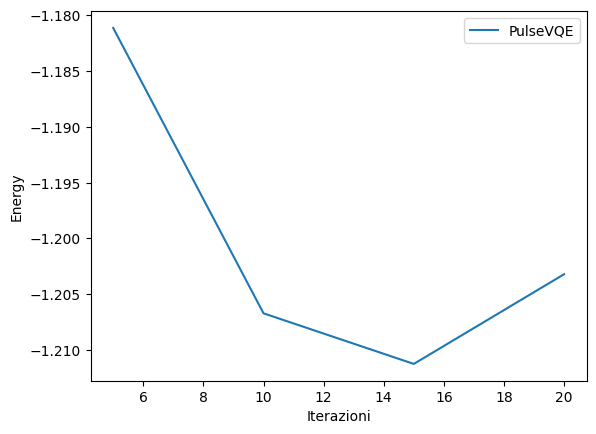

In [21]:
import matplotlib.pyplot as plt
plt.plot(iterazioni, energy, label="PulseVQE")
plt.xlabel("Iterazioni")
plt.ylabel("Energy")
plt.legend()
plt.savefig('H2-pVQE.png')
plt.show()